In [ ]:
import numpy as np
import ECM_notinversible_example as ecm
import os
import time
import numpy as np
import pandas as pd


In [ ]:

# ------------------------------------------------------------
# OUTPUT FOLDER
# ------------------------------------------------------------
OUT_DIR = r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Resultater"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------
# Settings
# ------------------------------------------------------
Ns = [100, 500, 1000, 10000]
M  = 10  

# True parameters
lam1_true = 2.0
lam2_true = 1.5
lam3_true = 1.0
q_true    = 0.4
r31_true  = 0.8
r32_true  = 1.2

#  Initialization tandomeness level
init_sd_rate = 1e-1
init_sd_q    = 1e-1

# Safety bounds
rate_min = 1e-3
q_min, q_max = 1e-4, 1 - 1e-4

# ------------------------------------------------------------
# Storage
# ------------------------------------------------------------
rows_summary = []
rows_runs    = []
rows_ll_traj = []

def is_monotone_nondecreasing(x, tol=1e-10):
    x = np.asarray(x, float)
    if x.size < 2:
        return True
    return bool(np.all(np.diff(x) >= -tol))



for N in Ns:
    time_list = []
    delta_po_list = []
    iters_list = []
    mono_list  = []
    conv_list  = []

    # NEW: store ll values for N-level means
    true_ll_list = []
    est_ll_list  = []

    fit_ok = 0
    ll_ok  = 0

    for m in range(M):
        # seed depends on (N,m)
        seed = 10_000 * m + N + 1234
        rng  = np.random.default_rng(seed)

        # ---- Simulate ----
        try:
            Y, _, _ = ecm.simulate_clara_dataset(
                lam1_true, lam2_true, lam3_true,
                q_true, r31_true, r32_true,
                N=N, rng=rng
            )
        except Exception as e:
            rows_runs.append({
                "N": N, "m": m, "seed": seed,
                "fit_success": False,
                "fit_error": f"simulation failed: {e}",
                "runtime_sec": np.nan,
                "lam1_0": np.nan, "lam2_0": np.nan, "lam3_0": np.nan,
                "q_0": np.nan, "r31_0": np.nan, "r32_0": np.nan,
                "lam1_hat": np.nan, "lam2_hat": np.nan, "lam3_hat": np.nan,
                "q_hat": np.nan, "r31_hat": np.nan, "r32_hat": np.nan,
                "ll_true": np.nan, "ll_est": np.nan,
                "ll_true_per_obs": np.nan, "ll_est_per_obs": np.nan,
                "delta_ll_per_obs": np.nan,
                "iters": np.nan, "ll_monotone": np.nan,
                "converged_flag": np.nan, "final_abs_dll_per_obs": np.nan,
                "ll_hist_len": np.nan,
            })
            continue

        # ---- Initialization (near truth + jitter) ----
        lam1_0 = max(lam1_true + rng.normal(scale=init_sd_rate), rate_min)
        lam2_0 = max(lam2_true + rng.normal(scale=init_sd_rate), rate_min)
        lam3_0 = max(lam3_true + rng.normal(scale=init_sd_rate), rate_min)

        r31_0  = max(r31_true  + rng.normal(scale=init_sd_rate), rate_min)
        r32_0  = max(r32_true  + rng.normal(scale=init_sd_rate), rate_min)

        q_0    = float(np.clip(q_true + rng.normal(scale=init_sd_q), q_min, q_max))

        # ---- Run ECM ----
        t0 = time.perf_counter()
        try:
            lam1_hat, lam2_hat, lam3_hat, q_hat, r31_hat, r32_hat, ll_hist = ecm.run_ecm_clara(
                Y,
                lam1_0=lam1_0,
                lam2_0=lam2_0,
                lam3_0=lam3_0,
                q_0=q_0,
                r31_0=r31_0,
                r32_0=r32_0,
                max_iter=200,
                max_R_inner_steps=1,
                rel_tol=1e-6,
                tol=1e-300,
                verbose=False,
                track_ll=True
            )
            t1 = time.perf_counter()
            runtime = t1 - t0
            fit_ok += 1
        except Exception as e:
            t1 = time.perf_counter()
            runtime = t1 - t0

            # record failure (save everything)
            rows_runs.append({
                "N": N, "m": m, "seed": seed,
                "fit_success": False,
                "fit_error": str(e),
                "runtime_sec": runtime,
                "lam1_0": lam1_0, "lam2_0": lam2_0, "lam3_0": lam3_0,
                "q_0": q_0, "r31_0": r31_0, "r32_0": r32_0,
                "lam1_hat": np.nan, "lam2_hat": np.nan, "lam3_hat": np.nan,
                "q_hat": np.nan, "r31_hat": np.nan, "r32_hat": np.nan,
                "ll_true": np.nan, "ll_est": np.nan,
                "ll_true_per_obs": np.nan, "ll_est_per_obs": np.nan,
                "delta_ll_per_obs": np.nan,
                "iters": np.nan, "ll_monotone": np.nan,
                "converged_flag": np.nan, "final_abs_dll_per_obs": np.nan,
                "ll_hist_len": np.nan,
            })
            continue

        # ---- Likelihoods (true vs estimated) ----
        ll_true_m = ecm.loglik_clara(
            Y, lam1_true, lam2_true, lam3_true, q_true, r31_true, r32_true
        )
        ll_est_m = ecm.loglik_clara(
            Y, lam1_hat, lam2_hat, lam3_hat, q_hat, r31_hat, r32_hat
        )

        if not (np.isfinite(ll_true_m) and np.isfinite(ll_est_m)):
            # record but exclude from N-level stats
            rows_runs.append({
                "N": N, "m": m, "seed": seed,
                "fit_success": True,
                "fit_error": "",
                "runtime_sec": runtime,
                "lam1_0": lam1_0, "lam2_0": lam2_0, "lam3_0": lam3_0,
                "q_0": q_0, "r31_0": r31_0, "r32_0": r32_0,
                "lam1_hat": lam1_hat, "lam2_hat": lam2_hat, "lam3_hat": lam3_hat,
                "q_hat": q_hat, "r31_hat": r31_hat, "r32_hat": r32_hat,
                "ll_true": float(ll_true_m), "ll_est": float(ll_est_m),
                "ll_true_per_obs": float(ll_true_m)/N if np.isfinite(ll_true_m) else np.nan,
                "ll_est_per_obs":  float(ll_est_m)/N if np.isfinite(ll_est_m) else np.nan,
                "delta_ll_per_obs": np.nan,
                "iters": int(len(ll_hist)) if ll_hist is not None else np.nan,
                "ll_monotone": np.nan,
                "converged_flag": np.nan, "final_abs_dll_per_obs": np.nan,
                "ll_hist_len": int(len(ll_hist)) if ll_hist is not None else np.nan,
            })
            continue

        ll_ok += 1

        true_ll_list.append(float(ll_true_m))
        est_ll_list.append(float(ll_est_m))

        # ---- ll trajectory diagnostics ----
        ll_hist = np.asarray(ll_hist, dtype=float) if ll_hist is not None else np.array([], float)
        ll_hist = ll_hist[np.isfinite(ll_hist)]
        iters = int(ll_hist.size)

        ll_hist_po = ll_hist / N if iters > 0 else np.array([], float)
        mono = is_monotone_nondecreasing(ll_hist, tol=1e-10)

        if iters >= 2:
            final_abs_dll_po = float(abs(ll_hist_po[-1] - ll_hist_po[-2]))
        else:
            final_abs_dll_po = np.nan

        # Convergence proxy in likelihood terms (matches your diagnostics plot)
        converged_flag = bool(iters >= 5 and np.isfinite(final_abs_dll_po) and final_abs_dll_po <= 1e-8)

        # ---- Save long-format trajectory (optional but useful for plotting) ----
        for k, llk in enumerate(ll_hist_po, start=1):
            rows_ll_traj.append({
                "N": N, "m": m, "seed": seed,
                "iter": k,
                "ll_per_obs": float(llk)
            })

        # ---- per-observation likelihood gap ----
        ll_true_po = float(ll_true_m) / N
        ll_est_po  = float(ll_est_m)  / N
        delta_po   = ll_est_po - ll_true_po

        # ---- Record all run-level values ----
        rows_runs.append({
            "N": N, "m": m, "seed": seed,
            "fit_success": True,
            "fit_error": "",
            "runtime_sec": runtime,
            "lam1_0": lam1_0, "lam2_0": lam2_0, "lam3_0": lam3_0,
            "q_0": q_0, "r31_0": r31_0, "r32_0": r32_0,
            "lam1_hat": float(lam1_hat), "lam2_hat": float(lam2_hat), "lam3_hat": float(lam3_hat),
            "q_hat": float(q_hat), "r31_hat": float(r31_hat), "r32_hat": float(r32_hat),
            "ll_true": float(ll_true_m), "ll_est": float(ll_est_m),
            "ll_true_per_obs": ll_true_po,
            "ll_est_per_obs": ll_est_po,
            "delta_ll_per_obs": float(delta_po),
            "iters": iters,
            "ll_monotone": mono,
            "converged_flag": converged_flag,
            "final_abs_dll_per_obs": final_abs_dll_po,
            "ll_hist_len": iters,
        })

        # ---- N-level accumulators ----
        time_list.append(runtime)
        delta_po_list.append(delta_po)
        iters_list.append(iters)
        mono_list.append(mono)
        conv_list.append(converged_flag)


    # Summaries for this N
  
    true_ll_arr = np.asarray(true_ll_list, dtype=float)
    est_ll_arr  = np.asarray(est_ll_list, dtype=float)

    mean_true_ll = float(np.mean(true_ll_arr)) if true_ll_arr.size else np.nan
    mean_est_ll  = float(np.mean(est_ll_arr))  if est_ll_arr.size  else np.nan

    delta_po_arr = np.asarray(delta_po_list, dtype=float)

    rows_summary.append({
        "N": N,
        "True_logLik_mean": mean_true_ll,
        "Est_logLik_mean":  mean_est_ll,
        "delta_ll_per_obs_mean": float(np.mean(delta_po_arr)) if delta_po_arr.size else np.nan,
        "delta_ll_per_obs_sd":   float(np.std(delta_po_arr, ddof=1)) if delta_po_arr.size > 1 else np.nan,
        "mean_time_sec":         float(np.mean(time_list)) if len(time_list) else np.nan,
        "fit_ok":                int(fit_ok),
        "ll_ok":                 int(ll_ok),
        "conv_rate":             float(np.mean(conv_list)) if conv_list else np.nan,
        "mono_rate":             float(np.mean(mono_list)) if mono_list else np.nan,
        "iters_median":          float(np.median(iters_list)) if iters_list else np.nan,
        "iters_p90":             float(np.quantile(iters_list, 0.90)) if iters_list else np.nan,
        "used_replications_for_ll": int(ll_ok),
        # record settings
        "max_iter": 200,
        "max_R_inner_steps": 1,
        "rel_tol": 1e-6,
        "tol": 1e-300,
    })

# Results tables 
df_summary = pd.DataFrame(rows_summary)
df_runs    = pd.DataFrame(rows_runs)
df_traj    = pd.DataFrame(rows_ll_traj)

summary_path = os.path.join(OUT_DIR, "clara_summary_diagnostics.csv")
runs_path    = os.path.join(OUT_DIR, "clara_runs_diagnostics.csv")
traj_path    = os.path.join(OUT_DIR, "clara_ll_trajectory_long.csv")

df_summary.to_csv(summary_path, index=False)
df_runs.to_csv(runs_path, index=False)
df_traj.to_csv(traj_path, index=False)

print(df_summary)



       N  True_logLik_mean  Est_logLik_mean  delta_ll_per_obs_mean  \
0    100       -169.785889      -167.673368               0.021125   
1    500       -858.002812      -855.130341               0.005745   
2   1000      -1749.427221     -1745.766090               0.003661   
3  10000     -17373.665786    -17371.642147               0.000202   

   delta_ll_per_obs_sd  mean_time_sec  fit_ok  ll_ok  conv_rate  mono_rate  \
0             0.017643       1.769681      10     10        1.0        1.0   
1             0.003894       8.419624      10     10        1.0        1.0   
2             0.002591      15.368295      10     10        1.0        1.0   
3             0.000087     759.209575      10     10        1.0        1.0   

   iters_median  iters_p90  used_replications_for_ll  max_iter  \
0          36.0       46.8                        10       200   
1          40.5       54.1                        10       200   
2          37.0       39.8                        10       2

In [46]:
df_summary

,N,True_logLik_mean,Est_logLik_mean,delta_ll_per_obs_mean,delta_ll_per_obs_sd,mean_time_sec,fit_ok,ll_ok,conv_rate,mono_rate,iters_median,iters_p90,used_replications_for_ll,max_iter,max_R_inner_steps,rel_tol,tol
0,100,-169.785889,-167.673368,0.021125,0.017643,1.769681,10,10,1.0,1.0,36.0,46.8,10,200,1,0.000001,1.000000e-300
1,500,-858.002812,-855.130341,0.005745,0.003894,8.419624,10,10,1.0,1.0,40.5,54.1,10,200,1,0.000001,1.000000e-300
2,1000,-1749.427221,-1745.766090,0.003661,0.002591,15.368295,10,10,1.0,1.0,37.0,39.8,10,200,1,0.000001,1.000000e-300
3,10000,-17373.665786,-17371.642147,0.000202,0.000087,759.209575,10,10,1.0,1.0,38.5,41.0,10,200,1,0.000001,1.000000e-300


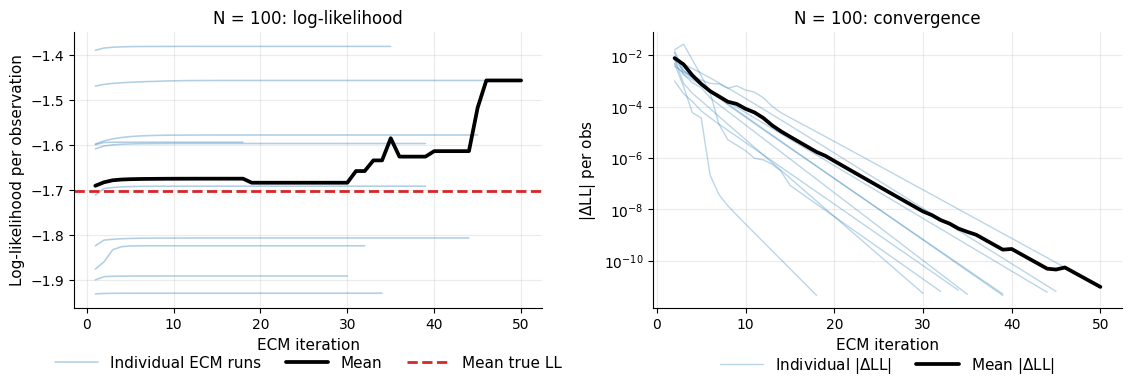

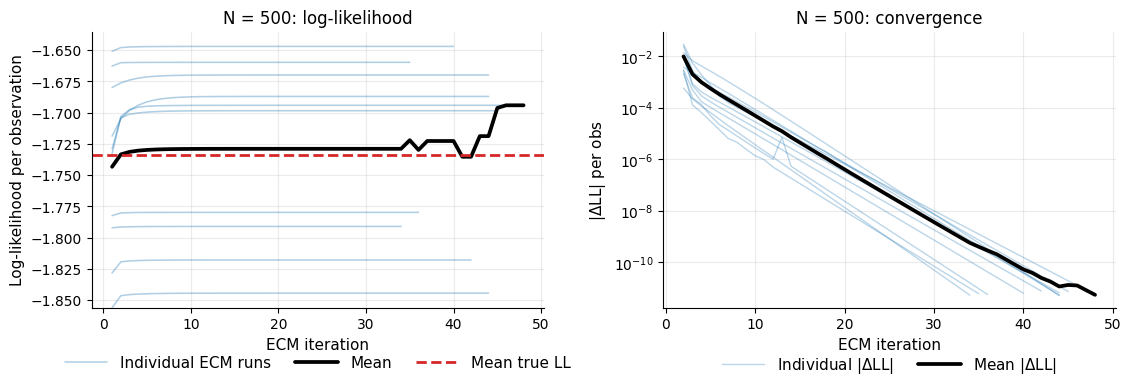

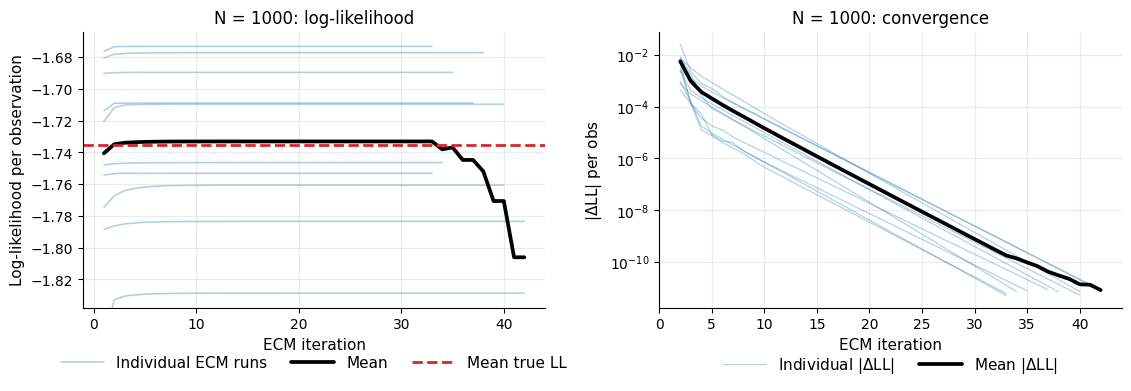

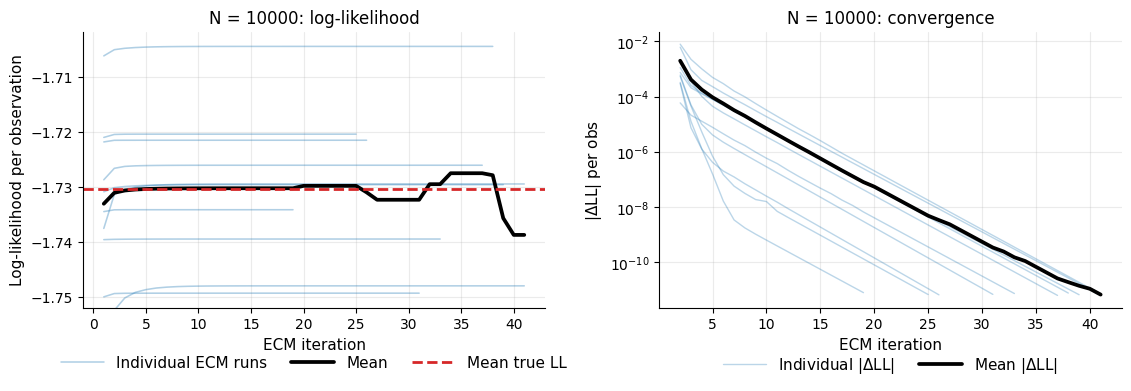

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


def pad_runs_to_matrix(runs):
    if not runs:
        return np.empty((0, 0))
    L = max(len(r) for r in runs)
    M = np.full((len(runs), L), np.nan, dtype=float)
    for i, r in enumerate(runs):
        rr = np.asarray(r, dtype=float)
        rr = rr[np.isfinite(rr)]
        M[i, :len(rr)] = rr
    return M


def plot_two_panel_per_N_clara(
    ll_hists_all,
    Ns,
    df,
    # scaling / central tendency
    per_obs=True,
    central="mean",  # "mean" or "median"
    # styling
    run_color="tab:blue",
    run_alpha=0.35,
    run_lw=1.15,
    central_color="black",
    central_lw=2.7,
    ref_color="tab:red",
    ref_lw=2.0,
    grid_alpha=0.25,
    # readability of LL panel
    clip_ll_y=True,
    yclip=(5, 95),
    # convergence panel
    eps=1e-12,
    # export
    out_dir=r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Figurer\Non_inverisble_known_path_clara",
    file_prefix="ECM_clara_knownpath",
    ref_col="True_logLik_mean",
):
    # --------------------------------------------------
    # Ensure output directory exists
    # --------------------------------------------------
    os.makedirs(out_dir, exist_ok=True)

    mpl.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
        "lines.solid_capstyle": "round",
        "savefig.dpi": 400,
    })

    Ns_sorted = sorted([N for N in Ns if len(ll_hists_all.get(N, [])) > 0])
    if not Ns_sorted:
        raise RuntimeError("No likelihood histories found in ll_hists_all.")

    for N in Ns_sorted:
        runs = ll_hists_all.get(N, [])
        if not runs:
            continue

        row = df.loc[df["N"] == N]
        if row.empty:
            raise RuntimeError(f"df missing row for N={N}.")
        ref_val = float(row[ref_col].values[0])
        if not np.isfinite(ref_val):
            raise RuntimeError(f"Reference df['{ref_col}'] not finite for N={N}.")

        scale = (1.0 / N) if per_obs else 1.0
        ref = ref_val * scale

        # Matrix of LL paths (padded)
        M_ll = pad_runs_to_matrix(runs) * scale

        # Central curve (LL)
        if central.lower() == "median":
            center_ll = np.nanmedian(M_ll, axis=0)
            center_label = "Median"
        else:
            center_ll = np.nanmean(M_ll, axis=0)
            center_label = "Mean"

        itc = np.arange(1, len(center_ll) + 1)

        # ---------------- Figure: 1x2 ----------------
        fig, (ax1, ax2) = plt.subplots(
            1, 2, figsize=(11.2, 3.8),
            constrained_layout=True
        )

        # ===== Left panel: log-likelihood trajectories =====
        all_vals = []
        for j, r in enumerate(runs):
            rr = np.asarray(r, float)
            rr = rr[np.isfinite(rr)]
            if rr.size == 0:
                continue
            rr = rr * scale
            it = np.arange(1, rr.size + 1)
            ax1.plot(
                it, rr,
                color=run_color, alpha=run_alpha, linewidth=run_lw,
                label="Individual ECM runs" if j == 0 else None
            )
            all_vals.append(rr)

        ax1.plot(itc, center_ll, color=central_color, linewidth=central_lw, label=center_label)
        ax1.axhline(ref, color=ref_color, linestyle="--", linewidth=ref_lw, label="Mean true LL")

        ax1.set_title(f"N = {N}: log-likelihood")
        ax1.set_xlabel("ECM iteration")
        ax1.set_ylabel("Log-likelihood per observation" if per_obs else "Log-likelihood")
        ax1.grid(True, alpha=grid_alpha)
        ax1.spines["top"].set_visible(False)
        ax1.spines["right"].set_visible(False)

        # Legend below plot (between axes and x-label)
        ax1.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=3,
            handlelength=2.8,
            columnspacing=1.6
        )

        if clip_ll_y and all_vals:
            vv = np.concatenate(all_vals)
            vv = vv[np.isfinite(vv)]
            if vv.size:
                lo, hi = np.percentile(vv, yclip)
                lo = min(lo, ref)
                hi = max(hi, ref)
                pad = 0.06 * (hi - lo) if hi > lo else 1.0
                ax1.set_ylim(lo - pad, hi + pad)

        # ===== Right panel: convergence diagnostic that SHOULD go to 0 =====
        # We plot |ΔLL_k| = |LL_k - LL_{k-1}| (per observation if per_obs=True).
        for j, r in enumerate(runs):
            rr = np.asarray(r, float)
            rr = rr[np.isfinite(rr)]
            if rr.size < 2:
                continue
            rr = rr * scale
            d = np.abs(np.diff(rr))
            it = np.arange(2, rr.size + 1)  # diffs correspond to iterations 2..T
            ax2.semilogy(
                it, np.maximum(d, eps),
                color=run_color, alpha=0.30, linewidth=1.0,
                label=r"Individual $|\Delta \mathrm{LL}|$" if j == 0 else None
            )

        # Central curve for |ΔLL|
        if M_ll.shape[1] >= 2:
            dM = np.abs(np.diff(M_ll, axis=1))
            if central.lower() == "median":
                center_d = np.nanmedian(dM, axis=0)
                d_label = r"Median $|\Delta \mathrm{LL}|$"
            else:
                center_d = np.nanmean(dM, axis=0)
                d_label = r"Mean $|\Delta \mathrm{LL}|$"

            itc_d = np.arange(2, len(center_d) + 2)
            ax2.semilogy(
                itc_d, np.maximum(center_d, eps),
                color=central_color, linewidth=central_lw, label=d_label
            )

        ax2.set_title(f"N = {N}: convergence")
        ax2.set_xlabel("ECM iteration")
        ax2.set_ylabel(r"$|\Delta \mathrm{LL}|$ per obs" if per_obs else r"$|\Delta \mathrm{LL}|$")
        ax2.grid(True, which="both", alpha=grid_alpha)
        ax2.spines["top"].set_visible(False)
        ax2.spines["right"].set_visible(False)

        # Legend below plot (between axes and x-label)
        ax2.legend(
            frameon=False,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=2,
            handlelength=2.8,
            columnspacing=1.6
        )

        # -------- Save --------
        pdf_path = os.path.join(out_dir, f"{file_prefix}_N{N}_two_panel.pdf")
        png_path = os.path.join(out_dir, f"{file_prefix}_N{N}_two_panel.png")
        fig.savefig(pdf_path, bbox_inches="tight")
        fig.savefig(png_path, bbox_inches="tight", dpi=400)

        plt.show()


# ---- Run export (uses your variables: ll_hists_all, Ns, df)
plot_two_panel_per_N_clara(
    ll_hists_all=ll_hists_all,
    Ns=Ns,
    df=df,
    per_obs=True,
    central="mean",
    out_dir=r"C:\Users\hhn54\OneDrive\Dokumenter\Speciale\Figurer\Non_inverisble_known_path_clara",
    file_prefix="ECM_clara_knownpath",
    clip_ll_y=True,
    yclip=(5, 95),
)


In [17]:
df_inits

,Init_label,Init_lam1_0,Init_lam2_0,Init_lam3_0,Init_q_0,Init_r31_0,Init_r32_0,var_lam1,se_lam1,rse_lam1,...,var_r31,se_r31,rse_r31,var_r32,se_r32,rse_r32,mean_iters,mean_time,True_logLik,Est_logLik
0,near_true,1.8,1.2,0.9,0.3,0.7,1.1,0.006101,0.006059,0.001515,...,0.000383,0.008670,0.013546,0.000742,0.021622,0.015015,41.84,28.283483,-1740.164009,-1737.816152
1,under_estimate,0.5,0.5,0.5,0.2,0.5,0.5,0.006127,0.006089,0.001522,...,0.002344,0.041801,0.065313,0.005591,0.098471,0.068383,48.10,45.439483,-1740.164009,-1737.816114
2,over_estimate,4.0,3.0,2.0,0.8,1.5,2.0,0.006071,0.006002,0.001501,...,0.008936,0.698585,1.091539,0.025069,1.550404,1.076669,45.98,59.624531,-1740.164009,-1737.817317
3,mixed_bad,0.3,3.0,0.2,0.7,0.2,2.5,0.006069,0.006000,0.001500,...,0.009883,0.029695,0.046398,0.022093,0.063778,0.044290,42.04,28.420235,-1740.164009,-1737.817234
